<a href="https://colab.research.google.com/github/Rparekh123/WalmartSalesTimeSeries/blob/main/Modeling_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
!pip install greykite
!pip install neuralprophet

# Business Overview

## What is Time Series Forecasting?
A sequence of data points collected often at a constant time interval of a given entity is known as time series. The measure question asked by any business is “how did the past influence the future?”. Forecasting is a process by which the future observation is estimated by using historical data. A statistical method that is used to analyze the data taken over time to forecast the future is known as time series forecasting. It is used to analyze time-based patterns in data and hence to determine a good model to forecast future behavior. Basically time series connect the past, present, and future.

## Use Cases / Aim
From  supply chain, stocks, biomedical monitoring etc. forecasting is used everywhere. For this project there are two main use cases for  forecasting. The first being store sales prediction to manage inventory demand and plan ahead accordingly. The second is ride-hailing demand for pricing and supply chain management. One of the importance of forecasting is if a holiday comes over how one should plan store sales to get maximum sales hence the profit.

## Data Description

The dataset used is Walmart store sales data. Walmart is an American multinational retail corporation that operates a chain of hypermarkets, department stores, and Grocery stores. The dataset provided is historical sales data for 45 Walmart stores located in different regions.  Each store contains many departments. Four different datasets are provided

- Stores.csv: This file contains information about the 45 stores,indicating the type and size of the store.
- Train.csv: This is the historical training data, which covers 2010-02-05 to 2012-11-01.
- Test.csv: This file is identical to train.csv, except for the weekly sales which have to be predicted. 
- Features.csv: This file contains additional data related to the store, department, and regional activity for the given dates. 

### Column Description
- Store - the store number
- Date - the week
- Dept - the department number
- Temperature - the average temperature in the region
- Fuel_Price - the cost of fuel in the region
- MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011 and is not available for all stores all the time. Any missing value is marked with an NA.
- CPI - the consumer price index
- Unemployment - the unemployment rate
- IsHoliday - whether the week is a special holiday week
- Weekly_Sales -  sales for the given department in the given store

## Importing Libraries and Loading Data

In [140]:
import numpy as np
import datetime
import pandas as pd
import pandas_profiling
import plotly
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import math



from neuralprophet import NeuralProphet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results
from greykite.framework.templates.autogen.forecast_config import ModelComponentsParam
from greykite.algo.changepoint.adalasso.changepoint_detector import ChangepointDetector
from greykite.framework.benchmark.data_loader_ts import DataLoaderTS
from greykite.framework.input.univariate_time_series import UnivariateTimeSeries

In [141]:
# Loading Data
train = pd.read_csv('new_train.csv')
test = pd.read_csv('new_test.csv')
df = pd.read_csv('dataframe.csv')

In [142]:
train

,Unnamed: 0,Store,ds,y,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,MarkDown5,CPI,Unemployment,Date_dayofweek,Date_month,Date_year,Date_day,IsHoliday_label,Type_B,Type_C
0,0,1,2010-02-05,1643690.90,151315,42.31,2.572,0.00,0.00,0.00,...,0.00,211.096358,8.106,4,2,2010,5,0,0,0
1,1287,10,2010-02-05,2193048.75,126512,54.34,2.962,0.00,0.00,0.00,...,0.00,126.442065,9.765,4,2,2010,5,0,1,0
2,5148,37,2010-02-05,536006.73,39910,45.97,2.572,0.00,0.00,0.00,...,0.00,209.852966,8.554,4,2,2010,5,0,0,1
3,2288,17,2010-02-05,789036.02,93188,23.11,2.666,0.00,0.00,0.00,...,0.00,126.442065,6.548,4,2,2010,5,0,1,0
4,4147,30,2010-02-05,465108.52,42988,39.05,2.572,0.00,0.00,0.00,...,0.00,210.752605,8.324,4,2,2010,5,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,3574,25,2012-10-26,688940.94,128107,56.69,3.882,4805.66,84.19,0.00,...,730.76,216.151590,7.293,4,10,2012,26,0,1,0
6431,714,5,2012-10-26,319550.77,34875,71.70,3.506,1547.61,1.74,0.00,...,598.74,224.037814,5.422,4,10,2012,26,0,1,0
6432,5719,40,2012-10-26,921264.52,155083,49.65,3.917,3605.71,55.98,0.28,...,1389.06,138.728161,4.145,4,10,2012,26,0,0,0
6433,2573,18,2012-10-26,1127516.25,120653,56.09,3.917,5430.61,128.31,50.00,...,969.64,138.728161,8.243,4,10,2012,26,0,1,0


In [143]:
train.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [144]:
train

,Store,ds,y,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Date_dayofweek,Date_month,Date_year,Date_day,IsHoliday_label,Type_B,Type_C
0,1,2010-02-05,1643690.90,151315,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,4,2,2010,5,0,0,0
1,10,2010-02-05,2193048.75,126512,54.34,2.962,0.00,0.00,0.00,0.00,0.00,126.442065,9.765,4,2,2010,5,0,1,0
2,37,2010-02-05,536006.73,39910,45.97,2.572,0.00,0.00,0.00,0.00,0.00,209.852966,8.554,4,2,2010,5,0,0,1
3,17,2010-02-05,789036.02,93188,23.11,2.666,0.00,0.00,0.00,0.00,0.00,126.442065,6.548,4,2,2010,5,0,1,0
4,30,2010-02-05,465108.52,42988,39.05,2.572,0.00,0.00,0.00,0.00,0.00,210.752605,8.324,4,2,2010,5,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,25,2012-10-26,688940.94,128107,56.69,3.882,4805.66,84.19,0.00,1073.49,730.76,216.151590,7.293,4,10,2012,26,0,1,0
6431,5,2012-10-26,319550.77,34875,71.70,3.506,1547.61,1.74,0.00,133.31,598.74,224.037814,5.422,4,10,2012,26,0,1,0
6432,40,2012-10-26,921264.52,155083,49.65,3.917,3605.71,55.98,0.28,486.81,1389.06,138.728161,4.145,4,10,2012,26,0,0,0
6433,18,2012-10-26,1127516.25,120653,56.09,3.917,5430.61,128.31,50.00,822.64,969.64,138.728161,8.243,4,10,2012,26,0,1,0


In [145]:
df

,ds,Store,y,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Date_dayofweek,Date_month,Date_year,Date_day,IsHoliday_label,Type_B,Type_C
0,2010-02-05,1,1643690.90,151315,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,4,2,2010,5,0,0,0
1,2010-02-05,10,2193048.75,126512,54.34,2.962,0.00,0.00,0.00,0.00,0.00,126.442065,9.765,4,2,2010,5,0,1,0
2,2010-02-05,37,536006.73,39910,45.97,2.572,0.00,0.00,0.00,0.00,0.00,209.852966,8.554,4,2,2010,5,0,0,1
3,2010-02-05,17,789036.02,93188,23.11,2.666,0.00,0.00,0.00,0.00,0.00,126.442065,6.548,4,2,2010,5,0,1,0
4,2010-02-05,30,465108.52,42988,39.05,2.572,0.00,0.00,0.00,0.00,0.00,210.752605,8.324,4,2,2010,5,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,2012-10-26,25,688940.94,128107,56.69,3.882,4805.66,84.19,0.00,1073.49,730.76,216.151590,7.293,4,10,2012,26,0,1,0
6431,2012-10-26,5,319550.77,34875,71.70,3.506,1547.61,1.74,0.00,133.31,598.74,224.037814,5.422,4,10,2012,26,0,1,0
6432,2012-10-26,40,921264.52,155083,49.65,3.917,3605.71,55.98,0.28,486.81,1389.06,138.728161,4.145,4,10,2012,26,0,0,0
6433,2012-10-26,18,1127516.25,120653,56.09,3.917,5430.61,128.31,50.00,822.64,969.64,138.728161,8.243,4,10,2012,26,0,1,0


In [146]:
df_store1 = df.loc[train['Store'] == 1]
df_store1 = df_store1.set_index('ds')
df_store1

,Store,y,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Date_dayofweek,Date_month,Date_year,Date_day,IsHoliday_label,Type_B,Type_C
ds,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1643690.90,151315,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,4,2,2010,5,0,0,0
2010-02-12,1,1641957.44,151315,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,4,2,2010,12,1,0,0
2010-02-19,1,1611968.17,151315,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,4,2,2010,19,0,0,0
2010-02-26,1,1409727.59,151315,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,4,2,2010,26,0,0,0
2010-03-05,1,1554806.68,151315,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,4,3,2010,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,1,1437059.26,151315,76.08,3.666,3666.27,7.64,1.65,1417.96,4744.28,222.981658,6.908,4,9,2012,28,0,0,0
2012-10-05,1,1670785.97,151315,68.55,3.617,8077.89,0.00,18.22,3617.43,3626.14,223.181477,6.573,4,10,2012,5,0,0,0
2012-10-12,1,1573072.81,151315,62.99,3.601,2086.18,0.00,8.11,602.36,5926.45,223.381296,6.573,4,10,2012,12,0,0,0


## Trend 
Trend is a pattern in data that shows the movement of a series to relatively higher or lower values over a long period of time. In other words, a trend is observed when there is an increasing or decreasing slope in the time series.

In [147]:
model = ChangepointDetector()
res = model.find_trend_changepoints(
 df=df_store1.reset_index(),  # data df
 time_col="ds",  # time column name
 value_col="y",  # value column name
 yearly_seasonality_order=10,  # yearly seasonality order, fit along with trend
 regularization_strength=0.5,  # between 0.0 and 1.0, greater values imply fewer changepoints, and 1.0 implies no changepoints
 resample_freq="7D",  # data aggregation frequency, eliminate small fluctuation/seasonality
 potential_changepoint_n=25,  # the number of potential changepoints
 yearly_seasonality_change_freq="365D",  # varying yearly seasonality for every year
 no_changepoint_distance_from_end="365D")  # the proportion of data from end where changepoints are not allowed
fig = model.plot(
 observation=True,
 trend_estimate=False,
 trend_change=True,
 yearly_seasonality_estimate=False,
 adaptive_lasso_estimate=True,
 plot=False)
plotly.io.show(fig)

## Seasonality

In [148]:
ts = UnivariateTimeSeries()
ts.load_data(
            df=df_store1.reset_index(),
            time_col="ds",
            value_col="y",
            freq="D")

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/greykite/common/time_properties.py:362: UserWarning:

Provided frequency 'D' does not match inferred frequency 'W-FRI'. Using 'D'.




In [149]:
fig = ts.plot_quantiles_and_overlays(
     groupby_time_feature="doy",  # day of quarter
     show_mean=True,
     show_quantiles=True,
     show_overlays=20,  # randomly selects up to 20 overlays
     # No explicit overlay feature. Each overlay is a single cycle (quarter)
     center_values=True,
     xlabel="day of year",
     ylabel=ts.original_value_col,
     title="Yearly seasonality",
 )
plotly.io.show(fig)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning:

All-NaN slice encountered




In [150]:
fig = ts.plot_quantiles_and_overlays(
     groupby_time_feature="dom",  # day of quarter
     show_mean=True,
     show_quantiles=True,
     show_overlays=20,  # randomly selects up to 20 overlays
     # No explicit overlay feature. Each overlay is a single cycle (quarter)
     center_values=True,
     xlabel="day of month",
     ylabel=ts.original_value_col,
     title="monthly seasonality",
 )
plotly.io.show(fig)

## Silverkite Model

In [151]:
df_store1.columns

Index(['Store', 'y', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1',
       'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Date_dayofweek', 'Date_month', 'Date_year', 'Date_day',
       'IsHoliday_label', 'Type_B', 'Type_C'],
      dtype='object')

In [152]:
# Specifies dataset information
metadata = MetadataParam(
     time_col="ds",  # name of the time column
     value_col="y",  # name of the value column
     freq="W-FRI",  #"MS" for Montly at start date, "H" for hourly, "D" for daily, "W" for weekly, etc.
     train_end_date=datetime.datetime(2012, 6, 8)
)

forecaster = Forecaster()
result = forecaster.run_forecast_config(
     df = df_store1.reset_index(),
     config = ForecastConfig(
         model_template=ModelTemplateEnum.SILVERKITE.name,
         forecast_horizon=20,  # forecasts 20 steps ahead
         coverage=0.95,  # 95% prediction intervals        
         metadata_param=metadata,
         model_components_param=ModelComponentsParam(
             autoregression=None,
             regressors={
             "regressor_cols": ['Temperature', 'IsHoliday_label', 'Fuel_Price']
             },
             events={
                 "holidays_to_model_separately": "auto",
                 "holiday_lookup_countries": ["UnitedStates"]
             },
              growth = {
                 "growth_term": "linear"
             },
             changepoints = {
                 "changepoints_dict": dict(
                     method="auto",
                     yearly_seasonality_order=10,
                     regularization_strength=0.5,
                     potential_changepoint_n=5,
                     yearly_seasonality_change_freq="365D",
                     no_changepoint_distance_from_end="365D"
                 )
             }
         )
    )
)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/greykite/algo/forecast/silverkite/forecast_simple_silverkite_helper.py:130: UserWarning:

Requested holiday 'Chinese New Year' does not occur in the provided countries


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/greykite/algo/forecast/silverkite/forecast_simple_silverkite_helper.py:130: UserWarning:

Requested holiday 'Good Friday' does not occur in the provided countries


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/greykite/algo/forecast/silverkite/forecast_simple_silverkite_helper.py:130: UserWarning:

Requested holiday 'Easter Monday [England, Wales, Northern Ireland]' does not occur in the provided countries




Fitting 3 folds for each of 1 candidates, totalling 3 fits


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/greykite/algo/changepoint/adalasso/changepoints_utils.py:1355: UserWarning:

No yearly seasonality changepoint added. Either data length is too short or yearly_seasonality_change_freq is too long.


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/greykite/algo/forecast/silverkite/forecast_silverkite.py:2560: UserWarning:

The granularity of data is larger than daily. Ensure the daily events data match the timestamps


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/greykite/algo/forecast/silverkite/forecast_silverkite.py:2560: UserWarning:

The granularity of data is larger than daily. Ensure the daily events data match the timestamps


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/greykite/algo/forecast/silverkite/forecast_silverkite.py:2560: UserWarning:

The granularity of data is larger than daily. Ensure the daily

In [153]:
result.forecast.compute_evaluation_metrics_split()

{'Test': {'CORR': 0.8806333781928694,
  'Coverage Diff: Actual_Coverage - Intended_Coverage': -0.04999999999999993,
  'Coverage: Lower Band': 0.6,
  'Coverage: Upper Band': 0.3,
  'MAE': 28228.931387309112,
  'MAPE': 1.7902097544973734,
  'MSE': 1637874469.0382228,
  'MedAE': 15678.59516444162,
  'MedAPE': 1.0433543954040454,
  'Outside Tolerance (fraction)': None,
  'OutsideTolerance1p': 0.5,
  'OutsideTolerance2p': 0.4,
  'OutsideTolerance3p': 0.25,
  'OutsideTolerance4p': 0.15,
  'OutsideTolerance5p': 0.15,
  'Prediction Band Coverage (fraction)': 0.9,
  'Prediction Band Width (%)': 11.091137613661276,
  'Q80': 10466.244921460395,
  'Q95': 8642.134535363317,
  'Q99': 8155.705099070763,
  'R2': 0.7520067133218196,
  'R2_null_model_score': None,
  'RMSE': 40470.661830988414,
  'sMAPE': 0.8886152742377718},
 'Train': {'CORR': 0.9645018864644828,
  'Coverage Diff: Actual_Coverage - Intended_Coverage': 0.0012195121951219523,
  'Coverage: Lower Band': 0.4959349593495935,
  'Coverage: Uppe

In [154]:
result.forecast.plot()

In [155]:
grid_search = result.grid_search
cv_results = summarize_grid_search_results(grid_search=grid_search, decimals=2,
    # The below saves space in the printed output. Remove to show all available metrics and columns.
    cv_report_metrics=None,
    column_order=["rank", "mean_test", "split_test", "mean_train", "split_train", "mean_fit_time", "mean_score_time", "params"])
# Transposes to save space in the printed output
cv_results["params"] = cv_results["params"].astype(str)
cv_results.set_index("params", drop=True, inplace=True)
cv_results.transpose()

params,[]
rank_test_MAPE,1
mean_test_MAPE,5.84
split_test_MAPE,"(9.43, 2.87, 5.24)"
mean_train_MAPE,2.64
split_train_MAPE,"(1.37, 3.75, 2.81)"
mean_fit_time,9.12
mean_score_time,1.25


## Neural Prophet Model

In [156]:
df = df_store1[['Temperature', 'Fuel_Price', 'IsHoliday_label', 'y']]

In [157]:
df = df.reset_index() 

In [158]:
df

,ds,Temperature,Fuel_Price,IsHoliday_label,y
0,2010-02-05,42.31,2.572,0,1643690.90
1,2010-02-12,38.51,2.548,1,1641957.44
2,2010-02-19,39.93,2.514,0,1611968.17
3,2010-02-26,46.63,2.561,0,1409727.59
4,2010-03-05,46.50,2.625,0,1554806.68
...,...,...,...,...,...
138,2012-09-28,76.08,3.666,0,1437059.26
139,2012-10-05,68.55,3.617,0,1670785.97
140,2012-10-12,62.99,3.601,0,1573072.81
141,2012-10-19,67.97,3.594,0,1508068.77


In [159]:
print(df.ds.min())
print(df.ds.max())

2010-02-05
2012-10-26


In [160]:
test_length = 20
df_train = df.iloc[:-test_length]
df_test = df.iloc[-test_length:]

In [161]:
model = NeuralProphet(loss_func='MSE', n_changepoints=2, seasonality_mode='additive')
model.add_future_regressor('Temperature')
model.add_future_regressor('Fuel_Price')
model.add_future_regressor('IsHoliday_label')

In [162]:
metrics = model.fit(df_train, freq="W")

INFO - (NP.df_utils._infer_frequency) - Major frequency W-FRI corresponds to 99.187% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 475


  0%|          | 0/108 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.72E-02, min: 1.16E+00


  0%|          | 0/108 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.37E-02, min: 6.50E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.98E-02
Epoch[475/475]: 100%|██████████| 475/475 [00:10<00:00, 43.94it/s, MSELoss=0.0454, MAE=8.33e+4, RMSE=1.14e+5, RegLoss=0]


In [163]:
future_df = model.make_future_dataframe(df_test, periods = test_length, n_historic_predictions=len(df_test), 
                                        regressors_df=df_test)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-FRI corresponds to 95.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


In [167]:
future_df = future_df.loc[20:]
future_df

,ds,Temperature,Fuel_Price,IsHoliday_label,y
20,2012-06-15,79.35,3.393,0,1630607.00
21,2012-06-22,78.39,3.346,0,1527845.81
22,2012-06-29,84.88,3.286,0,1540421.49
23,2012-07-06,81.57,3.227,0,1769854.16
24,2012-07-13,77.12,3.256,0,1527014.04
25,2012-07-20,80.42,3.311,0,1497954.76
26,2012-07-27,82.66,3.407,0,1439123.71
27,2012-08-03,86.11,3.417,0,1631135.79
28,2012-08-10,85.05,3.494,0,1592409.97
29,2012-08-17,84.85,3.571,0,1597868.05


In [168]:
forecast = model.predict(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-FRI corresponds to 95.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-FRI corresponds to 95.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


In [169]:
forecast.head()

,ds,y,yhat1,residual1,trend,season_yearly,future_regressors_additive,future_regressor_Fuel_Price,future_regressor_IsHoliday_label,future_regressor_Temperature
0,2012-06-15,1630607.00,1666571.500,35964.500,1522058.625,1619.256958,142893.625000,37963.292969,0.0,104930.343750
1,2012-06-22,1527845.81,1637165.375,109319.565,1524180.000,-25586.347656,138571.765625,35933.406250,0.0,102638.351562
2,2012-06-29,1540421.49,1602803.375,62381.885,1526301.375,-74973.171875,151475.250000,33342.050781,0.0,118133.195312
3,2012-07-06,1769854.16,1542842.750,-227011.410,1528422.750,-126604.429688,141024.484375,30793.890625,0.0,110230.585938
4,2012-07-13,1527014.04,1503465.250,-23548.790,1530544.125,-158731.437500,131652.609375,32046.375000,0.0,99606.234375


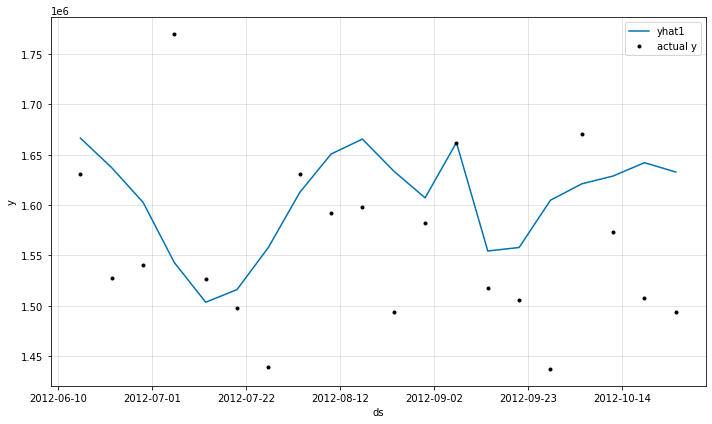

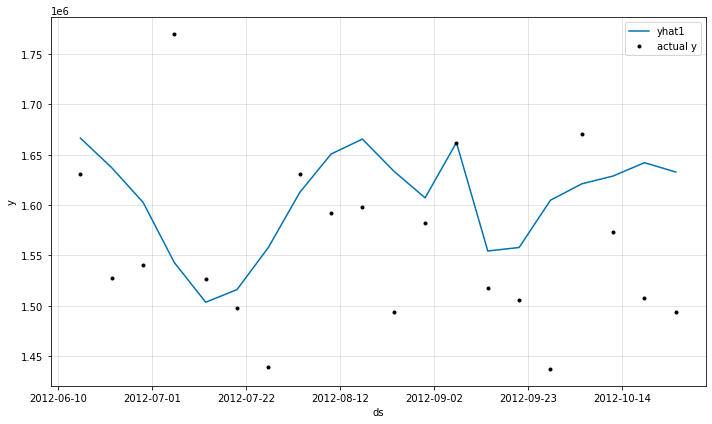

In [170]:
model.plot(forecast)

In [171]:
df_test['neural_prophet'] = forecast.iloc[-test_length:].loc[:, 'yhat1']

In [172]:
print(f"NeuralProphet:\t{mean_absolute_percentage_error(df_test['y'], forecast.iloc[-test_length:]['yhat1']):.4f}")

NeuralProphet:	0.0498


## Comparison between the two models

In [173]:
silverkite_df = result.forecast.df_test
prophet_df = forecast.head(test_length)

print(silverkite_df.shape, prophet_df.shape)

(20, 5) (20, 10)


In [174]:
silverkite_df.set_index('ds', inplace=True)
silverkite_df.head()

,actual,forecast,forecast_lower,forecast_upper
ds,,,,
2012-06-15,1630607.00,1.589291e+06,1.503012e+06,1.675570e+06
2012-06-22,1527845.81,1.574920e+06,1.488641e+06,1.661199e+06
2012-06-29,1540421.49,1.529353e+06,1.443074e+06,1.615632e+06
2012-07-06,1769854.16,1.673772e+06,1.587493e+06,1.760051e+06
2012-07-13,1527014.04,1.557756e+06,1.471477e+06,1.644035e+06


In [175]:
prophet_df.set_index('ds', inplace=True)
prophet_df.head()

,y,yhat1,residual1,trend,season_yearly,future_regressors_additive,future_regressor_Fuel_Price,future_regressor_IsHoliday_label,future_regressor_Temperature
ds,,,,,,,,,
2012-06-15,1630607.00,1666571.500,35964.500,1522058.625,1619.256958,142893.625000,37963.292969,0.0,104930.343750
2012-06-22,1527845.81,1637165.375,109319.565,1524180.000,-25586.347656,138571.765625,35933.406250,0.0,102638.351562
2012-06-29,1540421.49,1602803.375,62381.885,1526301.375,-74973.171875,151475.250000,33342.050781,0.0,118133.195312
2012-07-06,1769854.16,1542842.750,-227011.410,1528422.750,-126604.429688,141024.484375,30793.890625,0.0,110230.585938
2012-07-13,1527014.04,1503465.250,-23548.790,1530544.125,-158731.437500,131652.609375,32046.375000,0.0,99606.234375


In [176]:
print(f"Silverkite(MAPE):\t{mean_absolute_percentage_error(silverkite_df['actual'], silverkite_df['forecast']):.4f}")
print(f"NeuralProphet(MAPE:\t{mean_absolute_percentage_error(prophet_df['y'], prophet_df['yhat1']):.4f}")

print(f"Silverkite(RMSE):\t{math.sqrt(mean_squared_error(silverkite_df['actual'], silverkite_df['forecast'])):.4f}")
print(f"NeuralProphet(RMSE):\t{math.sqrt(mean_squared_error(prophet_df['y'], prophet_df['yhat1'])):.4f}")

Silverkite(MAPE):	0.0179
NeuralProphet(MAPE:	0.0498
Silverkite(RMSE):	40470.6618
NeuralProphet(RMSE):	96756.6493


<AxesSubplot:xlabel='ds'>

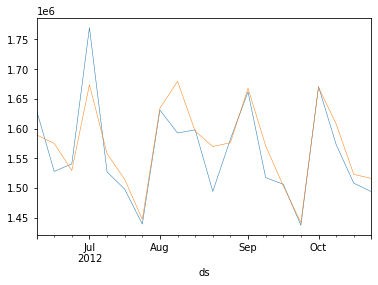

In [177]:
silverkite_df['actual'].plot(linewidth=0.5)
silverkite_df['forecast'].plot(linewidth=0.5)

<AxesSubplot:xlabel='ds'>

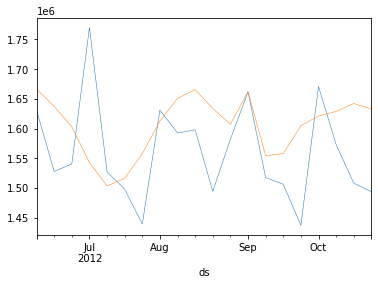

In [178]:
prophet_df['y'].plot(linewidth=0.5)
prophet_df['yhat1'].plot(linewidth=0.5)